In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt

import warnings
warnings.filterwarnings("ignore")

In [2]:
tickers = ['MSFT']

prices = yf.download(tickers,start='2020-01-01', end='2025-01-01')['Close']

returns = prices.pct_change().dropna()
returns.head()

C:\Users\samue\AppData\Local\Temp\ipykernel_17256\2219046847.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(tickers,start='2020-01-01', end='2025-01-01')['Close']
[*********************100%***********************]  1 of 1 completed


Ticker,MSFT
Date,
2020-01-03,-0.012452
2020-01-06,0.002585
2020-01-07,-0.009118
2020-01-08,0.015928
2020-01-09,0.012493


In [3]:
# Rendimiento promedio diario
mu = returns.mean()
mu * 100

Ticker
MSFT    0.098782
dtype: float64

In [4]:
# Rendimiento anual promedio
((1 + mu)**252 - 1) * 100

Ticker
MSFT    28.249575
dtype: float64

In [5]:
# Volatilidad diaria
vol = returns.std()
vol * 100

Ticker
MSFT    1.921145
dtype: float64

In [6]:
# Volatilidad anual
vol * np.sqrt(252) * 100

Ticker
MSFT    30.497226
dtype: float64

In [7]:
def get_data(ticker, start, end):
    data = yf.download(ticker, start=start, end=end, progress=False)['Close']
    returns = data.pct_change().dropna()
    mu = returns.mean()
    sigma = returns.std()
    return data, mu, sigma

In [8]:
data, mu, sigma = get_data('MSFT', '2020-01-01', '2025-01-01')
mu * 100, sigma * 100

C:\Users\samue\AppData\Local\Temp\ipykernel_17256\281825744.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end, progress=False)['Close']


(Ticker
 MSFT    0.098782
 dtype: float64,
 Ticker
 MSFT    1.921145
 dtype: float64)

In [9]:
# Obtener rendimientos y precios simulados
Z = np.random.normal(0, 1, 1000)
simulated_returns = np.array(mu) + np.array(sigma) * Z

# Rendimientos del activo modelados como mu + sigma * Z
# Z es una normal estándar

In [10]:
cumulative_returns = (1 + simulated_returns).cumprod()

In [11]:
cumulative_returns[-1] / cumulative_returns[0] - 1

np.float64(2.039113657061246)

In [12]:
initial_price = np.array(prices.iloc[-1])
initial_price

array([419.19656372])

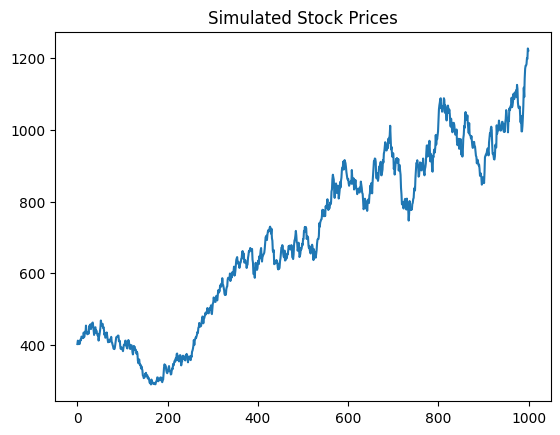

In [13]:
simulated_prices = initial_price * cumulative_returns

plt.plot(simulated_prices)
plt.title('Simulated Stock Prices')
plt.show()

---
## Función para simular precios futuros

Pasamos todo lo anterior visto a una función que recibe como parámetros la media, volatilidad, precios históricos y número de días a simular.

In [14]:
# Función para descargar datos de yfinance y calcular mu y sigma
def get_data(ticker, start, end):
    prices = yf.download(ticker, start=start, end=end, progress=False)['Close']
    returns = prices.pct_change().dropna()
    mu = returns.mean()
    sigma = returns.std()
    return prices, mu, sigma

In [15]:
# Función para simular precios futuros
def simular_precios(mu, sigma, prices, num_dias):
    Z = np.random.normal(0, 1, num_dias)
    simulated_returns = np.array(mu) + np.array(sigma) * Z
    cumulative_returns = (1 + simulated_returns).cumprod()
    initial_price = np.array(prices.iloc[-1])
    simulated_prices = initial_price * cumulative_returns
    return simulated_prices

C:\Users\samue\AppData\Local\Temp\ipykernel_17256\2386553773.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(ticker, start=start, end=end, progress=False)['Close']


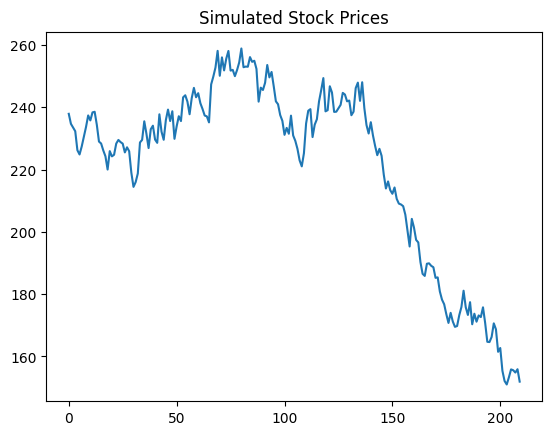

In [ ]:
#Ejemplos de una sola trayectoria simulada
prices, mu, sigma = get_data('AAPL', dt.datetime.now() - dt.timedelta(days=365 * 4), dt.datetime.now())

precios_simulados = simular_precios(mu, sigma, prices, 210)

plt.plot(precios_simulados)
plt.title('Simulated Stock Prices')
plt.show()

C:\Users\samue\AppData\Local\Temp\ipykernel_17256\2386553773.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(ticker, start=start, end=end, progress=False)['Close']


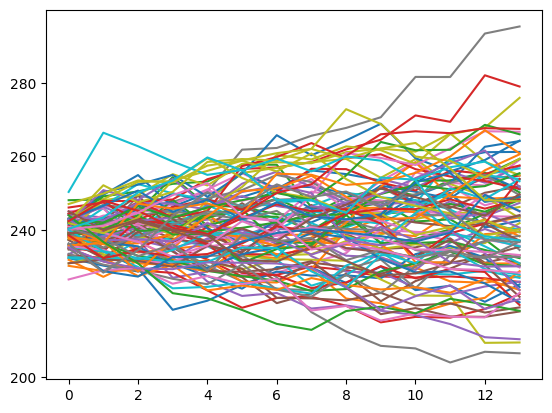

In [ ]:
# Caso de múltiples simulaciones
num_simulaciones = 100
num_dias = 14

trayectorias_de_precios = np.zeros((num_simulaciones, num_dias))

prices, mu, sigma = get_data('AAPL', dt.datetime.now() - dt.timedelta(days=365 * 4), dt.datetime.now())

for i in range(num_simulaciones):

    precios_simulados = simular_precios(mu, sigma, prices, num_dias)
    trayectorias_de_precios[i,:] = precios_simulados

plt.plot(trayectorias_de_precios.T)

---

## Portafolio

In [53]:
# Función para descargar datos de yfinance y calcular mu y sigma
def get_data_portafolio(ticker, start, end):
    prices = yf.download(ticker, start=start, end=end, progress=False)['Close']
    returns = prices.pct_change().dropna()
    mu = returns.mean()
    cov = returns.cov()
    return prices, mu, cov

def simular_precios_portafolio(num_simulaciones, w, mu, cov, prices, num_dias):

    # Matriz para contener los rendimientos del portafolio
    p_returns = np.full(shape = (num_simulaciones, num_dias), fill_value = 0.0)

    for i in range(num_simulaciones):
        L = np.linalg.cholesky(cov)
        Z = np.random.normal(0, 1, (num_dias, len(w)))
        daily_returns = np.array(mu) + Z @ L.T

        daily_p_returns = daily_returns @ w
        cumulative_returns = np.cumprod(1 + daily_p_returns)
        p_returns[i, :] = cumulative_returns

    return p_returns

num_simulaciones = 10000
num_dias = 14

trayectorias_de_precios = np.zeros((num_simulaciones, num_dias))

tickers = ['AAPL', 'MSFT', 'NVDA']
w = [0.5, 0.2, 0.3]
capital = 10000

prices, mu, cov = get_data_portafolio(tickers, dt.datetime.now() - dt.timedelta(days=365 * 4), dt.datetime.now())

p_returns = simular_precios_portafolio(num_simulaciones, w, mu, cov, prices, num_dias)

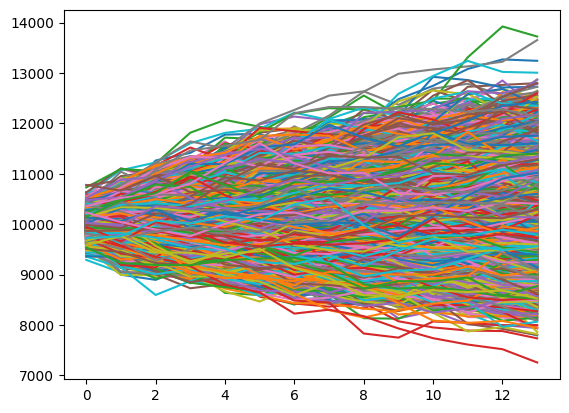

In [54]:
plt.plot(p_returns.T * capital)
plt.show()

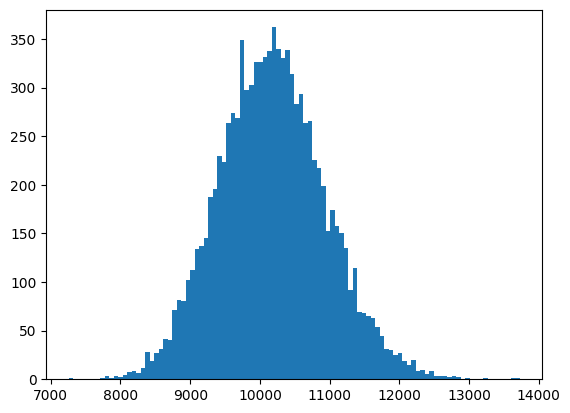

In [55]:
plt.hist(p_returns[:,-1] * capital, bins=100)
plt.show()

In [56]:
np.percentile(p_returns[:,-1] * capital, 2.5), np.percentile(p_returns[:,-1] * capital, 97.5)

(np.float64(8758.380787371903), np.float64(11728.83271306746))